In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Multiply
from tensorflow.keras.models import load_model


In [3]:
# Define paths
original_dataset_dir = r"C:\Users\jadha\Desktop\New folder\Sugarcane Disease Detection"
base_dir = r"C:\Users\jadha\Desktop\New folder\Sugarcane_Dataset"

categories = ['BrownRust', 'Dry', 'Healthy', 'Mawa', 'Mites', 'RedSpot', 'YellowLeaf']
os.makedirs(base_dir, exist_ok=True)

for split in ['train', 'validation', 'test']:
    for category in categories:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Function to split data
def split_data(source_dir, base_dir, split_ratios):
    for category in categories:
        source_category_dir = os.path.join(source_dir, category)
        files = os.listdir(source_category_dir)
        random.shuffle(files)

        train_split = int(len(files) * split_ratios[0])
        validation_split = train_split + int(len(files) * split_ratios[1])

        train_files = files[:train_split]
        validation_files = files[train_split:validation_split]
        test_files = files[validation_split:]

        for file in train_files:
            shutil.copy(os.path.join(source_category_dir, file), os.path.join(base_dir, 'train', category, file))
        for file in validation_files:
            shutil.copy(os.path.join(source_category_dir, file), os.path.join(base_dir, 'validation', category, file))
        for file in test_files:
            shutil.copy(os.path.join(source_category_dir, file), os.path.join(base_dir, 'test', category, file))

# Run split (only once!)
split_ratios = (0.7, 0.15, 0.15)
# split_data(original_dataset_dir, base_dir, split_ratios)


In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False)

print(train_generator.class_indices)


Found 3052 images belonging to 7 classes.
Found 918 images belonging to 7 classes.
Found 945 images belonging to 7 classes.
{'BrownRust': 0, 'Dry': 1, 'Healthy': 2, 'Mawa': 3, 'Mites': 4, 'RedSpot': 5, 'YellowLeaf': 6}


In [5]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
import tensorflow as tf

# Custom Dropout that stays active during inference
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)


from tensorflow.keras.layers import Lambda, Concatenate

# Define spatial attention using Keras layers
def spatial_attention(input_feature):
    # Channel-wise average and max pooling
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)

    # Concatenate and pass through Conv2D
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    # Multiply attention weights with input feature map
    return Multiply()([input_feature, attention])

# Define the CNN + Attention model
input_shape = (150, 150, 3)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 🧠 Apply spatial attention
x = spatial_attention(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = MCDropout(0.5)(x)
outputs = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 18, 18,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 18, 18, 1) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 18, 18, 1) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 18, 18, 2) │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 18, 18, 1) │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 18, 18,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 41472)     │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  5,308,544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout          │ (None, 128)       │          0 │ dense[0][0]       │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        903 │ mc_dropout[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,402,794 (20.61 MB)

 Trainable params: 5,402,794 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9278 - loss: 0.2248 - val_accuracy: 0.9553 - val_loss: 0.1609
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9238 - loss: 0.2242 - val_accuracy: 0.9619 - val_loss: 0.1471
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9389 - loss: 0.1913 - val_accuracy: 0.9444 - val_loss: 0.1531
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9378 - loss: 0.1818 - val_accuracy: 0.9553 - val_loss: 0.1336
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9503 - loss: 0.1629 - val_accuracy: 0.9303 - val_loss: 0.2272
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9194 - loss: 0.2538 - val_accuracy: 0.9542 - val_loss: 0.1165
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9484 - loss: 0.1532 - val_accuracy: 0.9695 - val_loss: 0.1019
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9375 - loss: 0.1889 - val_accuracy: 0.9782 - v

In [6]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


d:\anaconda\mainfile\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.1138 - loss: 1.9465
Test Accuracy: 11.64%
Test Loss: 1.9474


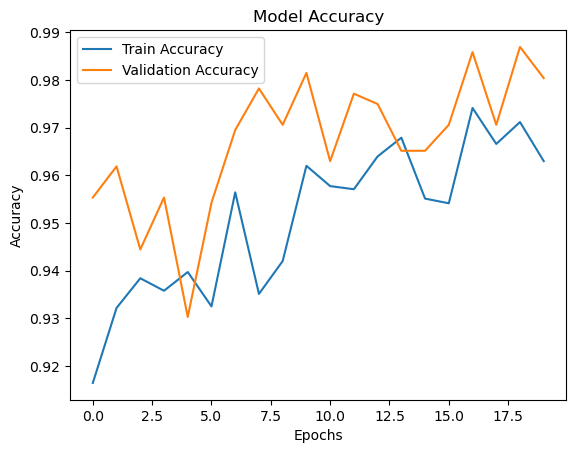

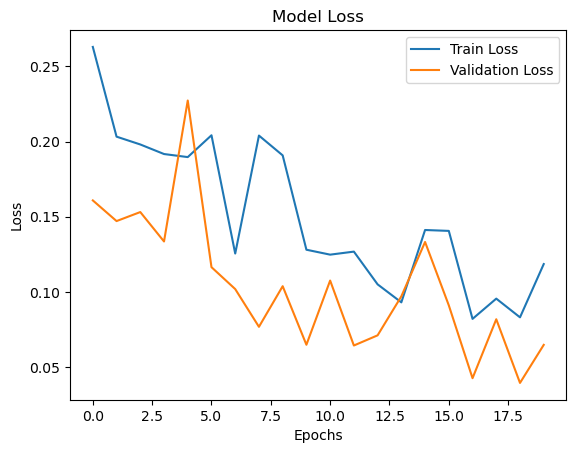

In [16]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [36]:
model.save('sugarcane_disease_model_with_attention.h5')
print("Model saved successfully!")

# Load it back
# model = load_model('sugarcane_disease_model_with_attention.h5', custom_objects={'Multiply': Multiply})


Model saved successfully!


In [7]:
# --- Block 9.5: Monte Carlo Dropout Prediction Function ---
def mc_prediction(model, img_array, n_iter=20):
    preds = []
    for _ in range(n_iter):
        preds.append(model(img_array, training=True))  # Force dropout ON
    preds = tf.stack(preds)
    mean_pred = tf.reduce_mean(preds, axis=0)
    std_pred = tf.math.reduce_std(preds, axis=0)
    return mean_pred.numpy(), std_pred.numpy()


In [10]:
# --- Block 9: Image Prediction with Confidence + MC Dropout ---
img_path = r"C:\Users\jadha\Desktop\New folder\detect1.jpeg"  # Your image path
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict with MC Dropout
mean_pred, std_pred = mc_prediction(model, img_array, n_iter=20)

# Extract confidence and uncertainty
confidence = np.max(mean_pred)
uncertainty = np.mean(std_pred)

# Get class names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
predicted_class = class_names[np.argmax(mean_pred)]

# Thresholds
confidence_thresh = 0.65
uncertainty_thresh = 0.1

if confidence < confidence_thresh or uncertainty > uncertainty_thresh:
    print("❌ Not a sugarcane leaf (unrecognized input)")
else:
    print(f"✅ Predicted Class: {predicted_class} (Confidence: {confidence:.2f}, Uncertainty: {uncertainty:.4f})")


❌ Not a sugarcane leaf (unrecognized input)


30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step


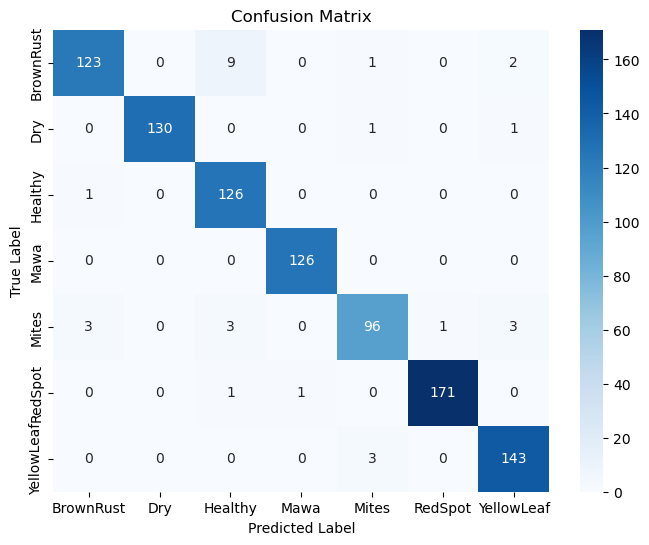

Classification Report:
              precision    recall  f1-score   support

   BrownRust       0.97      0.91      0.94       135
         Dry       1.00      0.98      0.99       132
     Healthy       0.91      0.99      0.95       127
        Mawa       0.99      1.00      1.00       126
       Mites       0.95      0.91      0.93       106
     RedSpot       0.99      0.99      0.99       173
  YellowLeaf       0.96      0.98      0.97       146

    accuracy                           0.97       945
   macro avg       0.97      0.97      0.97       945
weighted avg       0.97      0.97      0.97       945



In [39]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("your_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)
